### 8 Class Classification using TD-CNN-LSTM with a Balanced Dataset

In this notebook, 8 class classification of the surgical video clips is implemented with a TD-CNN-LSTM model. 700 video clips are taken for each class. The results will be compared with results from training the model with an unbalanced dataset to investigate the impact of imbalance of data on model performance.


In [ ]:
from google.colab import drive

In [ ]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2

#functions to read the video clips
class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=True):
        
        cap = cv2.VideoCapture(filename)

        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)

        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        
        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            try:
              frame = cv2.resize(frame, (self.height, self.width))
            except:
              print("break here")
              break
        
            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        
        return np.array(framearray)

In [ ]:
import argparse
import os

import matplotlib
matplotlib.use('AGG')

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import cifar10
from keras.layers import (Activation, Conv2D, Dense, Dropout, Flatten,
                          MaxPool2D, Input, ZeroPadding2D,TimeDistributed,LSTM)
import keras
from keras.layers import ELU, PReLU, LeakyReLU, Input
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from keras.backend import set_session

#function to load videos and labels from the given path to directory
def loaddata(video_dir, vid3d, nclass, color=False, skip=True):
    
    files = os.listdir(video_dir)  
    X = []
    labels = []
    pbar = tqdm(total=len(files))
    
    for filename in files:

        pbar.update(1)

        name = os.path.join(video_dir, filename)
        for v_files in os.listdir(name):
        
            v_file_path = os.path.join(name, v_files)
            
            X.append(vid3d.video3d(v_file_path, color=color, skip=skip))

            labels.append(int(name[-1]))

    pbar.close()

    if color:
        return np.array(X), labels
    else:
        return np.array(X), labels

The videos are loaded and resized to 112x112x3. The parameters for the model are set and the inputs along with the labels are reshaped.

In [ ]:
#parameters for dataset
depth = 16
img_rows, img_cols, frames = 112, 112, depth
channel = 3 
batch = 16
epoch = 30
videos = '/content/drive/MyDrive/BDD/clipped_videos'
color = True
skip = False
nclass = 8

vid3d = Videoto3D(img_rows, img_cols, frames)
nb_classes = 8
#return data in x and labels in y
x, y = loaddata(videos, vid3d, nclass, color, skip)

print(x.shape)

#reshape x and convert labels to categorical for the model
X = x.reshape((x.shape[0], frames, img_cols, img_rows, channel))
Y = np_utils.to_categorical(y,num_classes=nb_classes)

X = X.astype('float32')
    
print('\nX_shape:{}\nY_shape:{}'.format(X.shape, Y.shape))

The proposed TD-CNN-LSTM model is defined below.

In [ ]:
#define the model

cmodel = Sequential()
cmodel.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'), input_shape=(16, 112, 112, 3)))
cmodel.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
cmodel.add(TimeDistributed(MaxPool2D((2, 2), strides=(2, 2))))

cmodel.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
cmodel.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
cmodel.add(TimeDistributed(MaxPool2D((2, 2), strides=(2, 2))))

cmodel.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
cmodel.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
cmodel.add(TimeDistributed(MaxPool2D((2, 2), strides=(2, 2))))

cmodel.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
cmodel.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
cmodel.add(TimeDistributed(MaxPool2D((2, 2), strides=(2, 2))))

cmodel.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
cmodel.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
cmodel.add(TimeDistributed(MaxPool2D((2, 2), strides=(2, 2))))

cmodel.add(TimeDistributed(Flatten()))

cmodel.add(Dropout(0.5))
cmodel.add(LSTM(512, return_sequences=False, dropout=0.5))
cmodel.add(Dense(8, activation='softmax'))
cmodel.summary()

#define optimizer and compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
cmodel.compile(optimizer,loss=categorical_crossentropy,metrics=['accuracy'])

print(cmodel.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 56, 56, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 54, 54, 32)   9248      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 27, 27, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 27, 27, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 27, 27, 64)   3

Using StratifiedKFold, the model is repeatedly evaluated and the metrics are displayed.

0it [00:00, ?it/s]

kfold 1
Epoch 1/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0121 - accuracy: 0.9981
Epoch 2/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0027 - accuracy: 0.9994
Epoch 3/30
200/200 [==============================] - 5s 23ms/step - loss: 3.0433e-04 - accuracy: 1.0000
Epoch 4/30
200/200 [==============================] - 4s 22ms/step - loss: 1.5008e-04 - accuracy: 1.0000
Epoch 5/30
200/200 [==============================] - 5s 23ms/step - loss: 8.1406e-05 - accuracy: 1.0000
Epoch 6/30
200/200 [==============================] - 5s 23ms/step - loss: 5.8409e-05 - accuracy: 1.0000
Epoch 7/30
200/200 [==============================] - 5s 23ms/step - loss: 5.1065e-05 - accuracy: 1.0000
Epoch 8/30
200/200 [==============================] - 5s 23ms/step - loss: 4.2191e-05 - accuracy: 1.0000
Epoch 9/30
200/200 [==============================] - 5s 23ms/step - loss: 3.1585e-05 - accuracy: 1.0000
Epoch 10/30
200/200 [==============================] - 

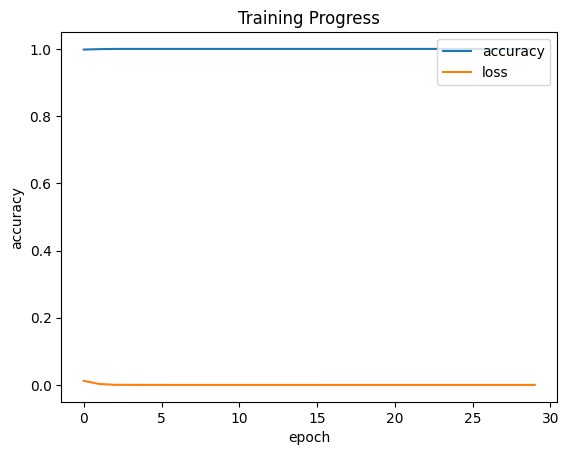

25/25 [==============================] - 1s 25ms/step


1it [02:29, 149.80s/it]

kfold 2
Epoch 1/30
200/200 [==============================] - 5s 23ms/step - loss: 0.3433 - accuracy: 0.8928
Epoch 2/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0994 - accuracy: 0.9684
Epoch 3/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0379 - accuracy: 0.9900
Epoch 4/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0285 - accuracy: 0.9906
Epoch 5/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0159 - accuracy: 0.9956
Epoch 6/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0171 - accuracy: 0.9962
Epoch 7/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0189 - accuracy: 0.9959
Epoch 8/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0049 - accuracy: 0.9994
Epoch 9/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0071 - accuracy: 0.9987
Epoch 10/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0114 

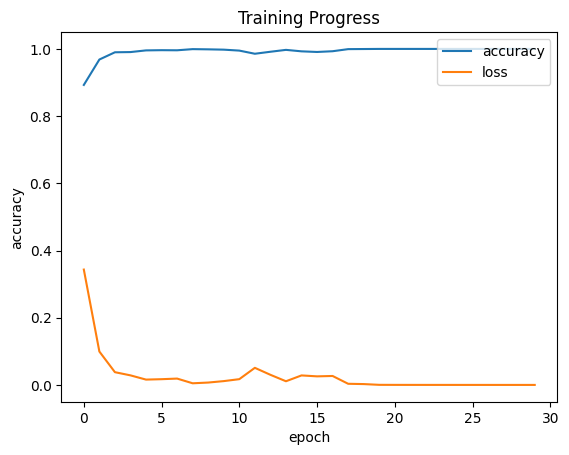

25/25 [==============================] - 1s 25ms/step


2it [04:57, 148.85s/it]

kfold 3
Epoch 1/30
200/200 [==============================] - 5s 23ms/step - loss: 0.1749 - accuracy: 0.9497
Epoch 2/30
200/200 [==============================] - 4s 22ms/step - loss: 0.0270 - accuracy: 0.9906
Epoch 3/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0120 - accuracy: 0.9962
Epoch 4/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0113 - accuracy: 0.9978
Epoch 5/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0015 - accuracy: 0.9997
Epoch 6/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0019 - accuracy: 0.9994
Epoch 7/30
200/200 [==============================] - 4s 22ms/step - loss: 6.0328e-04 - accuracy: 1.0000
Epoch 8/30
200/200 [==============================] - 5s 23ms/step - loss: 2.1700e-04 - accuracy: 1.0000
Epoch 9/30
200/200 [==============================] - 5s 23ms/step - loss: 1.3082e-04 - accuracy: 1.0000
Epoch 10/30
200/200 [==============================] - 5s 23ms/step - l

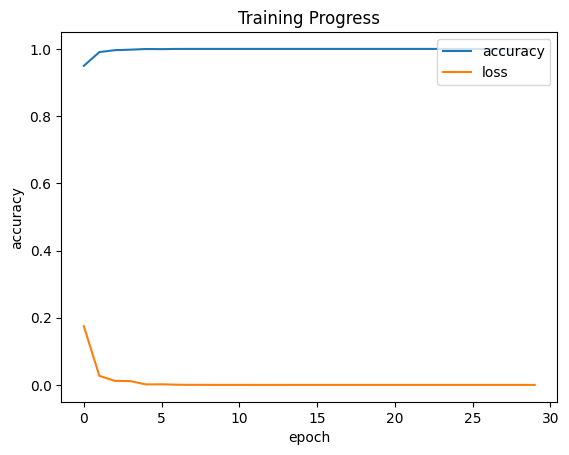

25/25 [==============================] - 1s 25ms/step


3it [07:25, 148.43s/it]

kfold 4
Epoch 1/30
200/200 [==============================] - 5s 23ms/step - loss: 0.1228 - accuracy: 0.9653
Epoch 2/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0630 - accuracy: 0.9800
Epoch 3/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0231 - accuracy: 0.9934
Epoch 4/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0054 - accuracy: 0.9984
Epoch 5/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0160 - accuracy: 0.9978
Epoch 6/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0213 - accuracy: 0.9944
Epoch 7/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0088 - accuracy: 0.9978
Epoch 8/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0021 - accuracy: 0.9991
Epoch 9/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0332 - accuracy: 0.9906
Epoch 10/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0125 

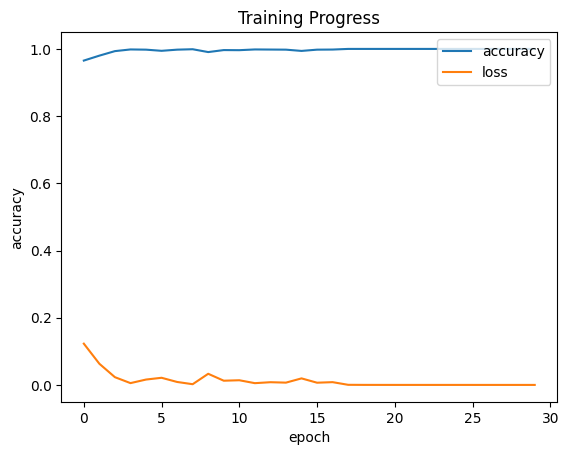

25/25 [==============================] - 1s 25ms/step


4it [09:54, 148.29s/it]

kfold 5
Epoch 1/30
200/200 [==============================] - 5s 23ms/step - loss: 0.1252 - accuracy: 0.9628
Epoch 2/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0136 - accuracy: 0.9944
Epoch 3/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0099 - accuracy: 0.9975
Epoch 4/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0015 - accuracy: 0.9997
Epoch 5/30
200/200 [==============================] - 5s 23ms/step - loss: 0.0032 - accuracy: 0.9997
Epoch 6/30
200/200 [==============================] - 5s 23ms/step - loss: 7.9882e-04 - accuracy: 0.9997
Epoch 7/30
200/200 [==============================] - 5s 23ms/step - loss: 2.0365e-04 - accuracy: 1.0000
Epoch 8/30
200/200 [==============================] - 5s 23ms/step - loss: 1.2145e-04 - accuracy: 1.0000
Epoch 9/30
200/200 [==============================] - 5s 23ms/step - loss: 8.7033e-05 - accuracy: 1.0000
Epoch 10/30
200/200 [==============================] - 5s 23ms/step

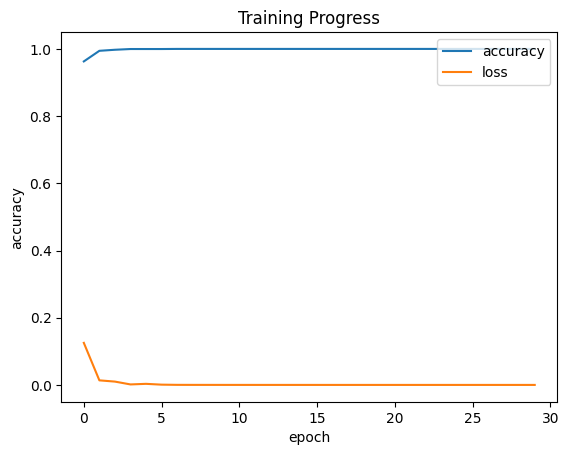

25/25 [==============================] - 1s 25ms/step


5it [12:21, 148.37s/it]


In [ ]:
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

#perform k-fold cross validation
scores, histories = list(), list()
Acc = []
preds = []
labs = []
predScore = []
kfold = StratifiedKFold(5, shuffle=True, random_state=1)
# enumerate splits
k = 0
s = 0
e = 1120
fold = 0
scaler = MinMaxScaler()

for train_ix, test_ix in tqdm(kfold.split(X,np.argmax(Y, axis=1))):
    print('kfold {}'.format(k+1)) 
    # select rows for train and test
    trainX, trainY, testX, testY = X[train_ix], Y[train_ix], X[test_ix], Y[test_ix]

    #scale imputs
    scaler.fit(trainX)
    trainX = scaler.transform(trainX)
    testX = scaler.transform(testX)
    
    # fit model
    history = cmodel.fit(trainX, trainY, batch_size=batch,
                    epochs=30, verbose=1, shuffle=True)
    
    histories.append(history)
    %matplotlib inline
    plt.plot(history.history['accuracy'])
    plt.title('Training Progress')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.plot(history.history['loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy','loss'], loc='upper right')
    plt.show()
    # evaluate model
    _, acc = cmodel.evaluate(testX, testY, verbose=0)
    # append scores
    scores.append(acc)
    #print('Accuracy: %.3f%% (+/- %.3f)' % (np.mean(scores)*100, np.std(scores)))
    rounded_predictions = cmodel.predict(testX)
    score = rounded_predictions
    rounded_predictions = np.argmax(np.round(rounded_predictions),axis=1)
    preds[s:e] = rounded_predictions
    predScore[s:e] = score
    labs[s:e] = testY
    rounded_labels=np.argmax(testY, axis=1)
    rounded_labels[1]
    Acc.append(np.count_nonzero(rounded_labels==rounded_predictions)/len(rounded_predictions)*100)
    s = s+1120
    e = e+1120
    k = k + 1

In [ ]:
#Evaluate performance 
rounded_labels=np.argmax(labs, axis=1)
print(classification_report(rounded_labels, preds))
Acc= (np.count_nonzero(rounded_labels==preds))/len(preds)*100
print('Acc:',Acc)
#Display confusion matrix
cm = confusion_matrix(rounded_labels, preds)
print(cm)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
print(scores)
#accuracy
print(Acc)
print('Cross Validation Accuracy:' , np.array(scores).mean()*100)

[0.9912499785423279, 0.9987499713897705, 0.9962499737739563, 0.9975000023841858, 0.9950000047683716]
99.575
Cross Validation Accuracy: 99.57499861717224


In [ ]:
cmodel.save('/content/drive/MyDrive/BDD/5stratifiedkfold_8class_Balanced.h5')